In [96]:
import numpy as np
import pandas as pd
import torch

from decifer.decifer_dataset import DeciferDataset
from decifer.decifer_model import Decifer, DeciferConfig
from decifer.tokenizer import Tokenizer
from bin.evaluate import extract_prompt, load_model_from_checkpoint
from decifer.utility import (
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
    disc_to_cont_xrd,
    disc_to_cont_xrd_from_cif,
)

In [10]:
# load a cif string and its xrd
dataset = DeciferDataset('../data/crystallm/full/serialized/test.h5', ['cif_string', 'cif_tokenized', 'xrd_disc.q', 'xrd_disc.iq'])
decode = Tokenizer().decode
padding_id = Tokenizer().padding_id
dataset_iter = iter(dataset)

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model_from_checkpoint('../experiments_11nov24/conditioning_mlp_augmentation/ckpt.pt', device)
model.eval()

number of total parameters: 26.14M


Decifer(
  (transformer): ModuleDict(
    (cond_embedding): Sequential(
      (0): Linear(in_features=1000, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (wte): Embedding(372, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=False)
          (c_proj): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): Layer

In [144]:
def rwp(sample, gen):
    """
    Calculates the residual (un)weighted profile between a sample and a generated XRD pattern
    """
    return np.sqrt(np.sum(np.square(sample - gen), axis=-1) / np.sum(np.square(sample), axis=-1))

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

0.62937


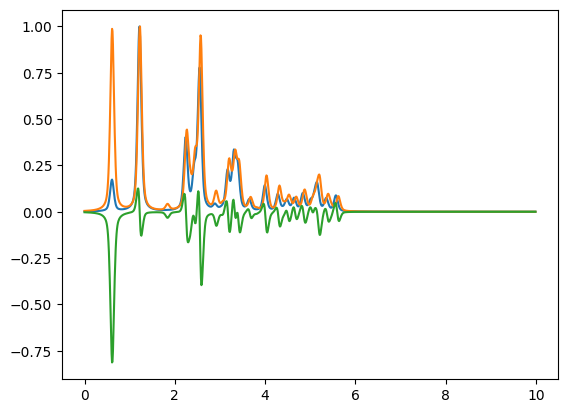

In [164]:
out = next(dataset_iter)
cif_string = out['cif_string']
cif_tokenized = out['cif_tokenized']
xrd_disc_q = out['xrd_disc.q']
xrd_disc_iq = out['xrd_disc.iq']

prompt = extract_prompt(cif_tokenized, model.device, add_composition=False, add_spacegroup=False).unsqueeze(0)

xrd_out = disc_to_cont_xrd(
    xrd_disc_q.unsqueeze(0), 
    xrd_disc_iq.unsqueeze(0),
    qmin = 0.0,
    qmax = 10.0,
    qstep = 0.01,
    fwhm_range = (0.1, 0.1),
    noise_range = (0.00, 0.00),
    mask_prob=0.0,
    intensity_scale_range=(1.0, 1.0)
)
iq = xrd_out['iq']
q = xrd_out['q']

import matplotlib.pyplot as plt
plt.plot(q, iq.squeeze(0))
    
cond_vec = iq.to(model.device)#.unsqueeze(0)

token_ids = model.generate_batched_reps(prompt, max_new_tokens=1000, cond_vec=cond_vec, start_indices_batch=[[0]]).cpu().numpy()
token_ids = [ids[ids != padding_id] for ids in token_ids]  # Remove padding tokens

out_cif = decode(list(token_ids[0]))
out_cif = replace_symmetry_loop_with_P1(out_cif)

# Extract space group symbol from the CIF string
spacegroup_symbol = extract_space_group_symbol(out_cif)

# If the space group is not "P1", reinstate symmetry
if spacegroup_symbol != "P 1":
    out_cif = reinstate_symmetry_loop(out_cif, spacegroup_symbol)

xrd_gen = disc_to_cont_xrd_from_cif(
    out_cif,
    qmin = 0.0,
    qmax = 10.0,
    qstep = 0.01,
    fwhm_range = (0.1, 0.1),
    noise_range = (0.0, 0.0),
    mask_prob=0.0,
    intensity_scale_range=(1.0, 1.0)
)
plt.plot(xrd_gen['q'], xrd_gen['iq'])
plt.plot(xrd_gen['q'],  iq.squeeze(0).numpy() - xrd_gen['iq'])
print(rwp(iq.squeeze(0).numpy(), xrd_gen['iq']))
plt.show()
    
# print(cif_string)
# print()
# print(out_cif)